## Library Support

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import nltk
from nltk.tokenize import word_tokenize, MWETokenizer

# got tired of warnings 🙃
import warnings
warnings.filterwarnings('ignore')

# Only need to run once
# nltk.download('punkt')

## Import Data from CSV

In [2]:
data_url = '../input/data-analyst-job-postings-google-search/gsearch_jobs.csv'
jobs_all = pd.read_csv(data_url).replace("'","", regex=True)
jobs_all.date_time = pd.to_datetime(jobs_all.date_time) # convert to date time
jobs_all = jobs_all.drop(labels=['Unnamed: 0', 'index'], axis=1, errors='ignore')
jobs_all.description_tokens = jobs_all.description_tokens.str.strip("[]").str.split(",")

## Data Integrity Check

In [3]:
print("Big Query Statistics:")
print("---------------------")
print(f"🚣‍♀️ Rows of data: {len(jobs_all)}")

repeat_jobs = jobs_all.job_id.value_counts()
try:
    repeat_jobs = repeat_jobs[repeat_jobs>1].index[0]
    repeat_jobs = len(repeat_jobs)
except IndexError:
    repeat_jobs = "None"
print(f"👯‍♀️ Number jobs repeated: {repeat_jobs}")

first_date = jobs_all.date_time.dt.date.min()
today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_dates) > 0:
    print("❌ Missing data for following dates:")
    for date in missing_dates:
        print(date)
else:
    print(f"✅ No missing dates of data since inception of: {first_date}")

delta_days = (today_date - (first_date - datetime.timedelta(days=2))).days # first day was actually day prior but UTC
jobs_day = round(len(jobs_all)/delta_days)
print(f"🧑‍💻 Average number of jobs per day: {jobs_day}")
print(f"📆 Collecting data for {delta_days} days now...")

Big Query Statistics:
---------------------
🚣‍♀️ Rows of data: 21555
👯‍♀️ Number jobs repeated: 976
❌ Missing data for following dates:
2022-12-28 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00
2023-06-27 00:00:00
🧑‍💻 Average number of jobs per day: 91
📆 Collecting data for 237 days now...


## Exploratory Data Analysis

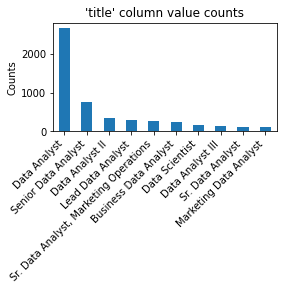

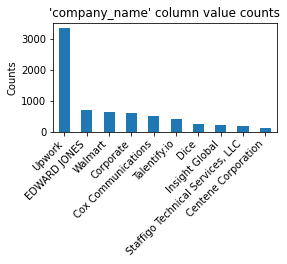

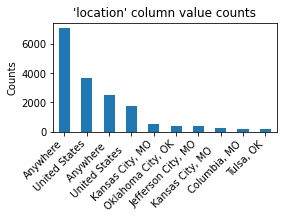

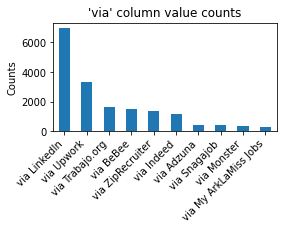

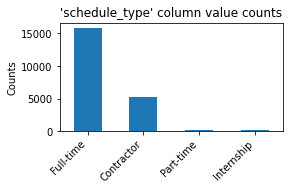

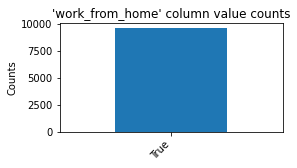

In [4]:
def eda_plot(column, topn=10):
    plt.figure(figsize=(4, 2))
    jobs_all[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 45, ha='right')
    plt.show()

columns = ['title', 'company_name', 'location', 'via', 'schedule_type', 'work_from_home']

for column in columns:
    eda_plot(column)


## Data Cleaning
This was previously done in the file import... but included for reference

#### Salary Cleaning - Find min, max, avg, hourly, & yearly

In [5]:
# Separate 'salary' column into that for min max avg and rate (e.g., hourly)
jobs_all[['salary_pay', 'salary_rate']] = jobs_all.salary.str.split(' ', 1, expand=True)
jobs_all.salary_pay = jobs_all.salary_pay.str.replace(',', '').str.replace('$', '').str.replace(' ', '')
jobs_all['salary_avg'] = np.where(jobs_all.salary_pay.str.contains("–"), np.NaN, jobs_all.salary_pay)  # The character U+2013 "–" could be confused with the character U+002d "-", which is more common in source code. Adjust settings
jobs_all['salary_min'] = np.where(jobs_all.salary_pay.str.contains("–"), jobs_all.salary_pay, np.NaN)
jobs_all[['salary_min', 'salary_max']] = jobs_all.salary_min.str.split("–", 1, expand=True)
for column in ['salary_avg', 'salary_min', 'salary_max']:
    jobs_all[column] = np.where(jobs_all[column].str.contains("K"), jobs_all[column].str.replace("K", "").astype(float) * 1000 , jobs_all[column] )
jobs_all['salary_avg'] = np.where(~jobs_all.salary_min.isnull(), (jobs_all.salary_min.astype(float) + jobs_all.salary_max.astype(float))/2 , jobs_all.salary_avg)
jobs_all['salary_hourly'] = np.where(jobs_all.salary_rate == 'an hour', jobs_all.salary_avg.astype(float), np.NaN)
jobs_all['salary_yearly'] = np.where(jobs_all.salary_rate == 'a year', jobs_all.salary_avg.astype(float), np.NaN)

# Standardize salary to all be annual
jobs_all['salary_standardized'] = np.NaN
salary_rate = {'a year': 1, 'an hour': 2080, 'a month': 12}
for key, index in salary_rate.items():
    jobs_all.salary_standardized = np.where(jobs_all.salary_rate == key, jobs_all.salary_avg.astype(float) * index, jobs_all.salary_standardized)

# Used to check results as built above
salary_df = jobs_all[~jobs_all.salary.isnull()]
salary_df = salary_df[['company_name', 'salary', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_standardized', 'salary_hourly', 'salary_yearly']] #, 'salary_min', 'salary_max']
pd.set_option('display.max_rows', salary_df.shape[0]+1)
salary_df.head(10)

,company_name,salary,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_standardized,salary_hourly,salary_yearly
6,Upwork,37–75 an hour,37–75,an hour,56.0,37,75,116480.0,56.0,NaN
13,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
23,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
33,Charles River Laboratories,65K–75K a year,65K–75K,a year,70000.0,65000.0,75000.0,70000.0,NaN,70000.0
43,Upwork,15–45 an hour,15–45,an hour,30.0,15,45,62400.0,30.0,NaN
73,Brooksource,40–45 an hour,40–45,an hour,42.5,40,45,88400.0,42.5,NaN
77,Upwork,45–65 an hour,45–65,an hour,55.0,45,65,114400.0,55.0,NaN
88,Insight Global,110K–135K a year,110K–135K,a year,122500.0,110000.0,135000.0,122500.0,NaN,122500.0
95,Upwork,15–50 an hour,15–50,an hour,32.5,15,50,67600.0,32.5,NaN
103,Insight Global,40–45 an hour,40–45,an hour,42.5,40,45,88400.0,42.5,NaN


Text(0.5, 0, '($USD/hr) Hourly Pay')

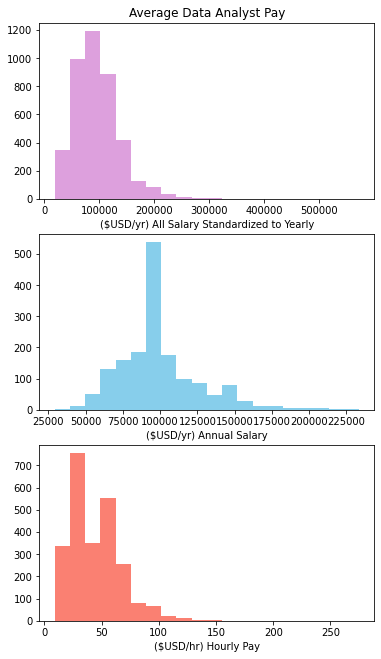

In [6]:
# plt.figure(figsize=(10, 2))
fig, axs = plt.subplots(3)
fig.set_figheight(11)
axs[0].hist(jobs_all.salary_standardized, bins = 20, color = 'plum')
axs[0].set_title("Average Data Analyst Pay")
axs[0].set_xlabel("($USD/yr) All Salary Standardized to Yearly")
axs[1].hist(jobs_all.salary_yearly, bins = 20, color = 'skyblue')
axs[1].set_xlabel("($USD/yr) Annual Salary")
axs[2].hist(jobs_all.salary_hourly, bins = 20, color = 'salmon')
axs[2].set_xlabel("($USD/hr) Hourly Pay")

#### Description Cleaning - Tokenize Languages & Tools

In [7]:
# Picked out keywords based on all keywords (only looked words with 100+ occurrences)
keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_analyst_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]

# Not using
keywords_general_tools = [
'microsoft', 'slack', 'apache', 'ibm', 'html5', 'datadog', 'bloomberg',  'ajax', 'persicope', 'oracle', 
]

# Not using
keywords_general = [
'coding', 'server', 'database', 'cloud', 'warehousing', 'scrum', 'devops', 'programming', 'saas', 'ci/cd', 'cicd', 
'ml', 'data_lake', 'frontend',' front-end', 'back-end', 'backend', 'json', 'xml', 'ios', 'kanban', 'nlp',
'iot', 'codebase', 'agile/scrum', 'agile', 'ai/ml', 'ai', 'paas', 'machine_learning', 'macros', 'iaas',
'fullstack', 'dataops', 'scrum/agile', 'ssas', 'mlops', 'debug', 'etl', 'a/b', 'slack', 'erp', 'oop', 
'object-oriented', 'etl/elt', 'elt', 'dashboarding', 'big-data', 'twilio', 'ui/ux', 'ux/ui', 'vlookup', 
'crossover',  'data_lake', 'data_lakes', 'bi', 
]

keywords = keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools 

jobs_all = jobs_all[jobs_all.description.notnull()] # filter out null values
jobs_all = jobs_all.reset_index() # throwing index issues if don't reset index
# jobs_all = jobs_all.head(10) 

jobs_all['description_tokens'] = ""
for index, row in jobs_all.iterrows():
    # lowercase words
    detail = row.description.lower()
    # tokenize words
    detail = word_tokenize(detail)
    # handle multi-word tokenization (e.g., 'Power BI')
    multi_tokens = [('power', 'bi'), ('data', 'lake'), ('data', 'lakes'), ('machine', 'learning'), ('objective', 'c'),
                    ('visual', 'basic')]
    tokenizer = MWETokenizer(multi_tokens)
    detail = tokenizer.tokenize(detail)
    # remove duplicates
    detail = list(set(detail))
    # filter for keywords only
    detail = [word for word in detail if word in keywords] 
    # replace duplicate keywords
    replace_tokens = {'powerbi' : 'power_bi', 'spreadsheets': 'spreadsheet'}
    for key, value in replace_tokens.items():
        detail = [d.replace(key, value) for d in detail]
    # add to details list # row.description_tokens = detail
    jobs_all.at[index, 'description_tokens'] = detail

## More EDA of Top Skills

In [8]:
def filtered_keywords(jobs_filtered, keywords, title="Keyword Analysis", head=10):
    # get keywords in a column
    count_keywords = pd.DataFrame(jobs_filtered.description_tokens.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')

    # get frequency of occurence of word (as word only appears once per line)
    length = len(jobs_filtered) # number of job postings
    count_keywords['percentage'] = 100 * count_keywords.counts / length

    # plot the results
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = plt.bar(x="keywords", height="percentage", data=count_keywords , color=np.random.rand(len(count_keywords.keywords), 3))
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.xticks(rotation = 45, ha='right')
    plt.title(title) 
    plt.show(g)
    print(count_keywords)

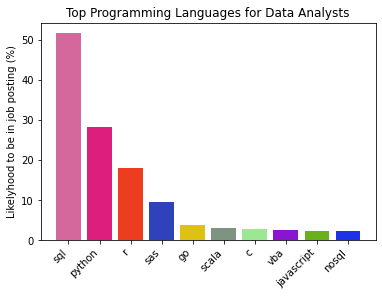

      keywords  counts  percentage
0          sql   11137   51.667826
3       python    6078   28.197634
5            r    3903   18.107168
6          sas    2068    9.594062
15          go     800    3.711436
19       scala     679    3.150081
22           c     608    2.820691
24         vba     541    2.509859
27  javascript     478    2.217583
28       nosql     477    2.212944


In [9]:
filtered_keywords(jobs_all, keywords_programming, title="Top Programming Languages for Data Analysts")

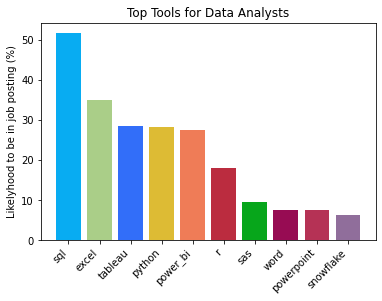

     keywords  counts  percentage
0         sql   11137   51.667826
1       excel    7547   35.012758
2     tableau    6112   28.355370
3      python    6078   28.197634
4    power_bi    5923   27.478543
5           r    3903   18.107168
6         sas    2068    9.594062
7        word    1645    7.631640
8  powerpoint    1638    7.599165
9   snowflake    1325    6.147066


In [10]:
filtered_keywords(jobs_all, keywords, title="Top Tools for Data Analysts")

#### Bonus: Skill vs. Salary

In [11]:
# Felt cute... may try to analyze later

# Skill Clusters
* Get a correlation matrix of skills that co-occur
* Cluster skills into co-occurring groups

In [12]:
jobs_all['description_tokens'].explode().value_counts()

sql              11137
excel             7547
tableau           6112
python            6078
power_bi          5923
r                 3903
sas               2068
word              1645
powerpoint        1638
snowflake         1325
aws               1242
azure             1153
spark              939
looker             916
spss               807
go                 800
spreadsheet        786
jira               778
sap                752
scala              679
microstrategy      653
alteryx            646
c                  608
hadoop             571
vba                541
outlook            520
sharepoint         512
javascript         478
nosql              477
java               476
ssrs               413
ssis               413
bigquery           406
qlik               405
mysql              344
redshift           338
gcp                292
pandas             273
visio              269
cognos             260
matlab             257
dax                253
pl/sql             244
git        

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Apply the MultiLabelBinarizer on the 'col' column
skills_mat = mlb.fit_transform(jobs_all['description_tokens'])

# Create a new DataFrame from the matrix
skills_df = pd.DataFrame(skills_mat, columns=mlb.classes_)

# drop rare - keep top 30 for better viz
skills_df = skills_df[
    jobs_all['description_tokens'].explode().value_counts().head(30).index.tolist()
]

# Print the result
skills_df.head(5)

,sql,excel,tableau,python,power_bi,r,sas,word,powerpoint,snowflake,...,microstrategy,alteryx,c,hadoop,vba,outlook,sharepoint,javascript,nosql,java
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = skills_df.corr()

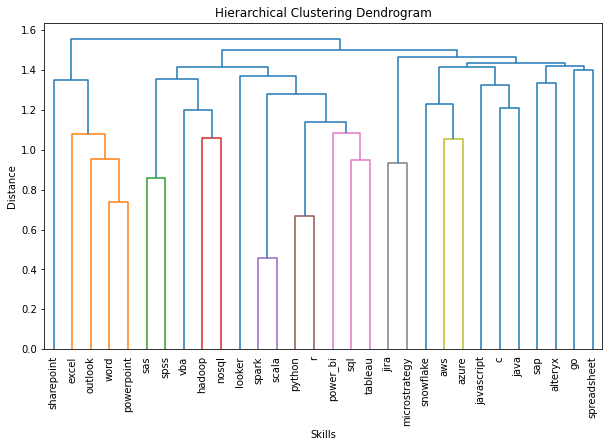

In [15]:
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Assuming you have a correlation matrix called 'corr'
# Create a distance matrix based on correlation coefficients
dist_matrix = 1 - corr.abs()

# Perform hierarchical clustering
linkage = hierarchy.linkage(dist_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage, labels=corr.index, leaf_rotation=90)
plt.xlabel('Skills')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

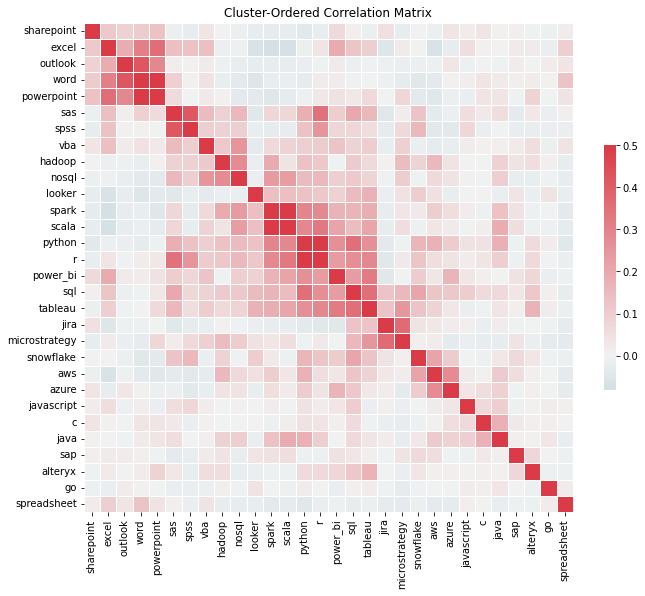

In [16]:
# Reorder the rows of the correlation matrix based on the clustering
ordered_corr = corr.iloc[dendrogram['leaves'], dendrogram['leaves']]

f, ax = plt.subplots(figsize=(11, 9))
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    ordered_corr, 
#     mask=mask, 
    cmap=cmap, vmax=0.5, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5}
)
plt.title('Cluster-Ordered Correlation Matrix')
plt.show()